Gita Rayung Andadari
<br>gita.rayungandadari@studenti.unipd.it
<br>2041509

Endrit Sveçla
<br>endrit.svecla@studenti.unipd.it
<br>2041500

#Brief Overview : 
 ***What are we working on? :*** 
<br>To classify which tweet that indicate natural disaster event. 
<br>
<br> ***Why are we doing this? :***
<br>Once the model is well trained, we can benefit this model to know real time natural disaster occurance report through twitter tweet .
<br>
<br> ***Goals :***
<br>To train a model that can classify natural disaster topic on twitter.


#Initialization

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import re
import warnings 
warnings.filterwarnings('ignore')
from google.colab import files

In [ ]:
def download_predictions_to_file(id_array, predictions_array):
  # This function, given a numpy array with the ids of the test tweets and a numpy array with the corresponding predictions, 
  # creates and let's you download a prediction file suitable to be uploaded to the Kaggle website

  id_array = id_array.reshape(len(id_array),1) # making sure the arrays are of the size requested by hstack(), i.e. (x,1) instead of (x,) 
  predictions_array = predictions_array.reshape(len(predictions_array),1)

  from google.colab import files
  result = pd.DataFrame(np.hstack((id_array, predictions_array)), columns=['id','target'])
  result.to_csv('prediction_file.csv', index=False)
  files.download('prediction_file.csv')


In [ ]:
def download_datasets(data_set):
  data_set.to_csv(data_set+'.csv', index=False)
  files.download(data_set+'.csv')

In [ ]:
import numpy as np
import pandas as pd 

data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",") 


In [ ]:
train_csv.shape, test_csv.shape

((7613, 5), (3263, 4))

In [ ]:
train_csv.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_csv.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#1. Data Analysis
In this section, the goal is to understand the data set that we are dealing with. 

- Check for Distribution of the dataset
- Check for training set class distribution 


- Check for null values
- Check for duplicates 


***Check for Distribution of dataset*** 
1. Based on number of words 
Pupose : We want to check if we have a good variation of the length of the tweet. We want our model to be able to detect for short, medium, and long tweet 

2. Length of tweet based on the category 
Purpose : We want to analyze the user behaviour. If they are in the middle of disaster would they send shorter or longer tweet 

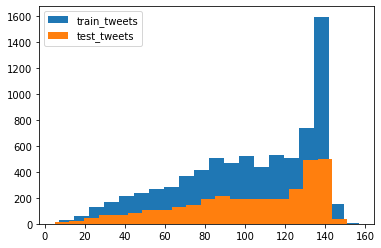

In [ ]:
#Distribution based on the amount of words 

length_train=train_csv['text'].str.len()
length_test=test_csv['text'].str.len()
plt.hist(length_train, bins=20, label = 'train_tweets')
plt.hist(length_test, bins=20, label='test_tweets')
plt.legend()
plt.show()

#Train and test dataset has similar distribution

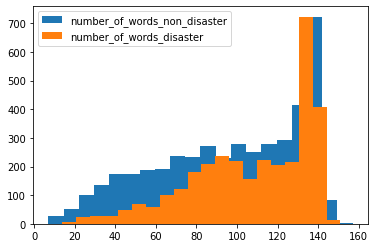

In [ ]:
#Length of tweet Distribution based on target 

length_train_0 = train_csv['text'].loc[train_csv['target']==0].str.len()
length_train_1 = train_csv['text'].loc[train_csv['target']==1].str.len()

plt.hist(length_train_0, bins=20, label = 'number_of_words_non_disaster')
plt.hist(length_train_1, bins=20, label='number_of_words_disaster')
plt.legend()
plt.show()

#This data can be interpreted as : people tend to share shorter tweet when reporting natural disaster occurancev

***Check for training set class distribution***

Purpose: To check if we have balance training set or not 

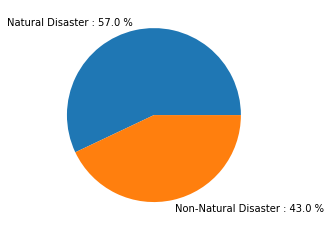

In [ ]:
#check the amount of 0 and 1 in each data sets 
import matplotlib.pyplot as plt

percentage_disaster = (train_csv.target.value_counts()/ len(train_csv.target)*100)
labels = ['Natural Disaster : '+str(np.round(percentage_disaster[0],1))+' %','Non-Natural Disaster : '+str(np.round(percentage_disaster[1]))+' %']
plt.pie(percentage_disaster, labels=labels)
plt.show() 

#notice that our dataset is imbalance. We have more non natural disaster tweet in the training set. 
#Hypothesis: This can make our future prediction to be more sensitive towards non natural disaster tweet 

***Check for null values***
<br>
In training and test set, null value appear in keyword and location variables. For training set, almost **half of the data** does not have location value. This is possible because user might turn off their location while sending the tweet. Furthermore, since the location describe the location where the tweet was sent rather than location of the occurance of natural disaster, location data does not have a strong correlation to wether a tweet marked as a natural disaster or not. For example, people can be from the USA and tweeting about a natural disaster in the Phillipines. 
<br>
<br>
For these reasons, we will not consider location data for our model. 

In [ ]:
print('Null Values in Training Set (In Percentage)')
print(train_csv.isnull().sum() / train_csv.count() * 100)
print('')
print('Null Values in Test Set (In Percentage)')
print(test_csv.isnull().sum() / test_csv.count() * 100)


Null Values in Training Set (In Percentage)
id           0.000000
keyword      0.807733
location    49.862205
text         0.000000
target       0.000000
dtype: float64

Null Values in Test Set (In Percentage)
id           0.000000
keyword      0.803213
location    51.204819
text         0.000000
dtype: float64


In our training set, for tweet marked as natural disaster, there are only about 1.3% of the tweet that does not contain a keyword. To overcome this issue, in data cleaning section we will replace these null value with empty strings 

In [ ]:
print('Null values in Training Set for Natural Disaster Tweet (In Percentage)')
train_csv.loc[train_csv['target']==1].isnull().sum() / train_csv.loc[train_csv['target']==1].count() * 100

Null values in Training Set for Natural Disaster Tweet (In Percentage)


id           0.000000
keyword      1.300712
location    48.952641
text         0.000000
target       0.000000
dtype: float64

For duplicated tweet, some of them does not have consisten target value. For example, take a look at the below tweets. For the same text, some marked as non disaster tweet and some marked as disaster tweet. This can be confusing for our program during the training phase. 
<br>
<br>
For this reason, we will remove duplicated tweet in our training set. 

In [ ]:
train_csv.loc[train_csv['text']=="The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'"]

,id,keyword,location,text,target
4284,6087,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4286,6090,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save you...,0
4292,6097,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,1
4304,6111,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4309,6118,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4318,6132,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,1


#2. Data Cleaning

- Text cleaning: Removing non-alphabetic character (emoji, punctuation, hashtag, etc), lowering the text, remove http link 
- Remove duplicated tweets in the training set 
- Fill null values of the features [keyword] and [location] with ' '
- Add keyword at the end of the text for disaster tweet 
- Removing stopwords, Contracting, and Lemmatizing (Tokenization) the tweet

##***Text Cleaning***

In [ ]:
for i in range(len(train_csv)):
  train_csv['text'][i] = re.sub('http[s]?://\S+', '', train_csv['text'][i])
  train_csv['text'][i] = train_csv['text'][i].lower()
  train_csv['text'][i] = re.sub("[^a-zA-Z]"," ",train_csv['text'][i])
  train_csv['text'][i] = re.sub(' +', ' ',train_csv['text'][i])

  train_csv['keyword'][i] = re.sub('http[s]?://\S+', '', str(train_csv['keyword'][i]))
  train_csv['keyword'][i] = train_csv['keyword'][i].lower()
  train_csv['keyword'][i] = re.sub("[^a-zA-Z]"," ",train_csv['keyword'][i])
  train_csv['keyword'][i] = re.sub(' +', ' ',train_csv['keyword'][i])

##***Remove duplicated tweets in the training set***

1056 Duplicated tweets in the training data 
<br>Those duplicated tweets consist of 325 different tweets. 
<br>Some of them have identical text but different embedded links. Since we are not considering http links in a tweet, we will mark those as duplicated. 
<br>Furthermore, to avoid confusion in the model training phase, these duplicated tweets will be deleted from the training data. 
<br>
<br>33 tweets from the test are also duplicated
<br>However, we are not going to delete the one in the test set because we need the full dataset to submit to kaggle. 

In [ ]:
s = train_csv['text'].value_counts() 
s = s.to_frame(name='ct')
s = s['ct'].loc[s['ct']>1]
s

watch this airport get swallowed up by a sandstorm in under a minute                                          24
wreckage conclusively confirmed as from mh malaysia pm investigators and the families of those who were       20
families to sue over legionnaires more than families affected by the fatal outbreak of legionnaires disea     19
 hot funtenna hijacking computers to send data as sound waves black hat prebreak best                         17
christian attacked by muslims at the temple mount after waving israeli flag via pamela geller                 15
                                                                                                              ..
why are you engulfed by low self image take the quiz                                                           2
 killed in two simultaneous rail crash as acute floods derail the two trains india mumbai                      2
rt notexplained the only known image of infamous hijacker d b cooper                            

In [ ]:
#Number of duplicated 
print('Number of duplicated tweet: ',sum(s))
print('Number of unique duplicated tweet : ', len(set(s.index)))

Number of duplicated tweet:  1056
Number of unique duplicated tweet :  325


In [ ]:
s = train_csv['text'].value_counts() 
s = s.to_frame(name='ct')
s = s['ct'].loc[s['ct']>1]
d = set(s.index)
train_text=[]
y_train_full = []
keyword_train = []
for i in range(len(train_csv)):  
  if train_csv['text'].iloc[i] not in d:
    #print(train_csv['text'].iloc[i])
    train_text.append(train_csv['text'][i].strip())
    y_train_full.append(train_csv['target'][i])
    keyword_train.append(train_csv['keyword'][i])

##***Fill null values of the features [keyword] and [location] with ''***

In [ ]:
train_csv["keyword"].fillna('', inplace = True)
train_csv["location"].fillna('', inplace = True)
test_csv["keyword"].fillna('', inplace = True)
test_csv["location"].fillna('', inplace = True)

##***Add keyword at the beginning of the text for disaster tweet***
<br>
Purpose: To emphasize keyword for a good indicator of disaster tweet


In [ ]:
#to "convert" string into HTML format 
from html.parser import HTMLParser 
html_parser = HTMLParser()

In [ ]:
# preparing new column for "cleaned tweet" placeholder 

train_text = html_parser.unescape(train_text)
test_text = test_csv['text'].copy().apply(lambda x: html_parser.unescape(x))

In [ ]:
#add keyword at the beginning of tweet if target = 1

for i in range(len(train_text)):
  if y_train_full[i] == 1: 
    train_text[i] = str(keyword_train[i]) + ' ' + train_text[i]

#train_text

In [ ]:
#do the same for the test set 
#but since test csv does not have target we will just add the keyword regardless the target 
for i in range(len(test_text)):
    test_text[i] = str(test_csv['keyword'][i]) + ' ' + test_csv['text'][i] 
 
test_text

0                      Just happened a terrible car crash
1        Heard about #earthquake is different cities, ...
2        there is a forest fire at spot pond, geese ar...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258     EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FAST...
3259     Storm in RI worse than last hurricane. My cit...
3260     Green Line derailment in Chicago http://t.co/...
3261     MEG issues Hazardous Weather Outlook (HWO) ht...
3262     #CityofCalgary has activated its Municipal Em...
Name: text, Length: 3263, dtype: object

##***Removing stopwords, Lemmatizing (Tokenization), and contracting the tweet*** 

Tokenization: converting the text from a set of symbols to a sequence of
word/tokens

In [ ]:
#fixing the contraction text 
#you're = you are 
!pip install contractions 

     |████████████████████████████████| 321 kB 4.9 MB/s 
     |████████████████████████████████| 284 kB 49.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85434 sha256=4b006d9358f83f13082279c2c6bdfe96b78be6e706a1a4b0f2ed2eff2580a54e
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import contractions 
for i,text in enumerate(train_text):
  #print(i)
  train_text[i] = contractions.fix(train_text[i])

for i in range(len(test_text)):
  test_text[i] = contractions.fix(test_text[i])

In [ ]:
#lemmatizing the word :

import nltk #natural language tool kit 
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords #['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", ... 
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#processing the training set 

for i,text in enumerate(train_text):
  lst=[]
  vector = text.split()
  for word in vector: 
    if word not in stop_word and len(word)>3:
      lst.append(stemmer.lemmatize(word,pos="v"))
  train_text[i]=' '.join(lst)
    
#[^a-zA-Z] means any character that IS NOT a-z OR A-Z 
#substitute it with nothing a.k.a remove it 
#train_text

In [ ]:
#Processing the test set 
for i,text in enumerate(test_text):
  test_text[i] = re.sub('http[s]?://\S+', '', test_text[i])
  test_text[i] = test_text[i].lower()
  test_text[i] = re.sub("[^a-zA-Z]"," ",test_text[i])
  test_text[i] = re.sub(' +', ' ',test_text[i])
  vector = test_text[i].split()
  lst=[]
  for word in vector:     
    if word not in stop_word and len(word)>3:
      lst.append(stemmer.lemmatize(word,pos="v"))
  test_text[i]=' '.join(lst)
    

#[^a-zA-Z] means any character that IS NOT a-z OR A-Z
#substitute it with nothing a.k.a remove it 
print(test_text[0:10])

0                                happen terrible crash
1    hear earthquake different cities stay safe eve...
2    forest fire spot pond geese flee across street...
3                   apocalypse light spokane wildfires
4                   typhoon soudelor kill china taiwan
5                                     shake earthquake
6     would probably still show life arsenal yesterday
7                                                     
8                                                 nice
9                                                 fuck
Name: text, dtype: object


In [ ]:
def cleaner(tweet):
  # Acronyms and miswritten words
  tweet = re.sub(r"Typhoon-Devastated", "typhoon devastated", tweet)
  tweet = re.sub(r"TyphoonDevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"typhoondevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"MH370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"MH", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"mh370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"year-old", "years old", tweet)
  tweet = re.sub(r"yearold", "years old", tweet)
  tweet = re.sub(r"yr old", "years old", tweet)
  tweet = re.sub(r"PKK", "Kurdistan Workers Party", tweet)
  tweet = re.sub(r"MP", "madhya pradesh", tweet)
  tweet = re.sub(r"rly", "railway", tweet)
  tweet = re.sub(r"CDT", "Central Daylight Time", tweet)
  tweet = re.sub(r"sensorsenso", "sensor senso", tweet)
  tweet = re.sub(r"pm", "", tweet)
  tweet = re.sub(r"PM", "", tweet)
  tweet = re.sub(r"nan", " ", tweet)
  tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
  tweet = re.sub(r"epicente", "epicenter", tweet)
  tweet = re.sub(r"epicenterr", "epicenter", tweet)
  tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
  tweet = re.sub(r"prebreak", "pre break", tweet)
  tweet = re.sub(r"nowplaying", "now playing", tweet)
  tweet = re.sub(r"RT", "retweet", tweet)
  tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
  tweet = re.sub(r"LondonFire", "London Fire", tweet)
  tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
  tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
  tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
  tweet = re.sub(r"withweapons", "with weapons", tweet)
  tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
  tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
  tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
  tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)

  return tweet

In [ ]:
#for the training set 
for k,text in enumerate(train_text):
  train_text[k] = cleaner(text)
  
#for the test set 
for k,text in enumerate(test_text):
  test_text[k] = cleaner(text)

In [ ]:
#combined the cleaned tweet to the dataframe 
#train_csv['cleaned']=train_text 
test_csv['cleaned']=test_text

#3. Vectorization of the Training and Test Data 

Vectorization is a way to transform our charater test and training set into numerical measure. This process is important because the targeted machine learning model that we will use later only accept numerical input instead of character. We are using **bag-of-words** model to simplify the word representation of each tweet. Therefore, each tweet is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. 

In this project, we are going to experiment with 2 different vectorizers : 

1. CountVectorizer 
2. TF-IDF 

There are 2 type of experiments that will be conducted against each vectorizer. Below are the objectives of each experiment : 
1. To find a good combination of each vectorizing model. 
2. To find the minimum number of words needed to obtain good enough prediction 

In [ ]:
#import the required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

##CountVectorizer 

CountVectorizer convert a collection of text documents to a matrix of token counts. 
1. CountVectorizer trained to find all unique word in training set 
2. For each tweet, count how many unique words from step 1 existed, mark 0 if a word does not exist 
3. The output of this process is a matrix with the size of **(**amount of tweet **,** amount of unique words in all the tweets) 

In [ ]:
text = train_text
model = CountVectorizer(ngram_range = (1, 1))
matrix = model.fit_transform(text).toarray()
train_out = pd.DataFrame(data = matrix, columns = model.get_feature_names())
print(train_out.T.iloc[34:39])
print(train_out.shape)

           0     1     2     3     4     ...  6552  6553  6554  6555  6556
abortions     0     0     0     0     0  ...     0     0     0     0     0
abouts        0     0     0     0     0  ...     0     0     0     0     0
abran         0     0     0     0     0  ...     0     0     0     0     0
absence       0     0     0     0     0  ...     0     0     0     0     0
absolut       0     0     0     0     0  ...     0     0     0     0     0

[5 rows x 6557 columns]
(6557, 12677)


###Finding the optimum NGram combination for CountVectorizer 
We will try a number of ngram combination against Perceptron, LogisticRegression, Decission Tree, Random Forest, and SVM model. Further exploration of the model will be done in section 4. 

In [ ]:
#NGram Perceptron
nn_num = [1,2]
for i in nn_num: 
  feature_computer = CountVectorizer(ngram_range=(i,i))
  train_features = feature_computer.fit_transform(train_text).toarray()
  test_features = feature_computer.transform(test_text).toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = Perceptron()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"Perceptron.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:{i}")


Perceptron.	Train:0.9996	Val:0.8800	Ngrams:1
Perceptron.	Train:0.9998	Val:0.7065	Ngrams:2


In [ ]:
#Ngram (1,2) for Perceptron
feature_computer = CountVectorizer(ngram_range=(1,2))
train_features = feature_computer.fit_transform(train_text).toarray()
test_features = feature_computer.transform(test_text).toarray()
X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = Perceptron()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"Perceptron.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:(1,2)")


Perceptron.	Train:1.0000	Val:0.8765	Ngrams:(1,2)


In [ ]:
#Deciding Ngram for DecissionTree
nn_num = [1,2]
for i in nn_num: 
  feature_computer = CountVectorizer(ngram_range=(i,i))
  train_features = feature_computer.fit_transform(train_text).toarray()
  test_features = feature_computer.transform(test_text).toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)

  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"DecisionTree.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:{i}")

DecisionTree.	Train:1.0000	Val:0.9612	Ngrams:1
DecisionTree.	Train:0.9998	Val:0.7022	Ngrams:2


In [ ]:
#Ngram (1,2) for DecissionTree
feature_computer = CountVectorizer(ngram_range=(1,2))
train_features = feature_computer.fit_transform(train_text).toarray()
test_features = feature_computer.transform(test_text).toarray()
X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"DecisionTree.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:(1,2)")


DecisionTree.	Train:1.0000	Val:0.9215	Ngrams:(1,2)


In [ ]:
#Deciding Ngram for RandomForest
nn_num = [1,2]
for i in nn_num: 
  feature_computer = CountVectorizer(ngram_range=(i,i))
  train_features = feature_computer.fit_transform(train_text).toarray()
  test_features = feature_computer.transform(test_text).toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)

  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"RandomForest.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:{i}")

RandomForest.	Train:1.0000	Val:0.9376	Ngrams:1
RandomForest.	Train:0.9996	Val:0.6624	Ngrams:2


In [ ]:
#Ngram (1,2) for RandomForest
feature_computer = CountVectorizer(ngram_range=(1,2))
train_features = feature_computer.fit_transform(train_text).toarray()
test_features = feature_computer.transform(test_text).toarray()
X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"RandomForest.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:(1,2)")


RandomForest.	Train:1.0000	Val:0.9328	Ngrams:(1,2)


In [ ]:
#Deciding Ngram for LogisticRegression
nn_num = [1,2]
for i in nn_num: 
  feature_computer = CountVectorizer(ngram_range=(i,i))
  train_features = feature_computer.fit_transform(train_text).toarray()
  test_features = feature_computer.transform(test_text).toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = LogisticRegression()
  clf.fit(X_train, y_train)

  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"LogisticRegression.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:{i}")

LogisticRegression.	Train:0.9842	Val:0.8950	Ngrams:1
LogisticRegression.	Train:0.9932	Val:0.6685	Ngrams:2


In [ ]:
#Ngram (1,2) for LogisticRegression
feature_computer = CountVectorizer(ngram_range=(1,2))
train_features = feature_computer.fit_transform(train_text).toarray()
test_features = feature_computer.transform(test_text).toarray()
X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = LogisticRegression()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"LogisticRegression.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:(1,2)")


LogisticRegression.	Train:0.9982	Val:0.8793	Ngrams:(1,2)


In [ ]:
#Deciding Ngram for SVC
nn_num = [1,2]
for i in nn_num: 
  feature_computer = CountVectorizer(ngram_range=(i,i))
  train_features = feature_computer.fit_transform(train_text).toarray()
  test_features = feature_computer.transform(test_text).toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = SVC()
  clf.fit(X_train, y_train)

  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:{i}")

SVC.	Train:0.9852	Val:0.8973	Ngrams:1
SVC.	Train:0.9641	Val:0.6830	Ngrams:2


In [ ]:
#Ngram (1,2) for SVC
feature_computer = CountVectorizer(ngram_range=(1,2))
train_features = feature_computer.fit_transform(train_text).toarray()
test_features = feature_computer.transform(test_text).toarray()
X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = SVC()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNgrams:(1,2)")


SVC.	Train:0.9812	Val:0.8630	Ngrams:(1,2)


###Count Vectorizer - Number of words 
From the previous NGram experiment, ngram = 1 works best for all the model. Therefore, from this point onwards we will continue with ngram = 1 as one of the parameter. 

In this part, our goal is to determine the minimum number of words needed to obtain good enough prediction for each model 

In [ ]:
nword_exp = {'model': ['model'], 'val':[0], 'train':[0], 'nword':[0]}
nword_exp = pd.DataFrame.from_dict(nword_exp)

In [ ]:
nword_exp_det = {'model': ['model'], 'val':[0], 'train':[0], 'nword':[0]}
nword_exp_det = pd.DataFrame.from_dict(nword_exp_det)

In [ ]:
#Finding the smallest number using perceptron
num = [250, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000, 7000, 9000, 12000 ]
score_tr = []
score_val = []
for i in num: 
  feature_computer = CountVectorizer(binary = True, max_features= i)
  train_features = feature_computer.fit_transform(train_text)
  train_features = train_features.toarray()
  test_features = feature_computer.transform(test_text)
  test_features = test_features.toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = Perceptron()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"Perceptron.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNumword:{i}")
  score_tr.append(f1_score(y_train, y_train_pred,average = 'macro'))
  score_val.append(f1_score(y_val, y_val_pred,average = 'macro'))
  nword_exp = nword_exp.append({'model': 'Perceptron', 'val':f1_score(y_val, y_val_pred,average = 'macro'), 'train':f1_score(y_train, y_train_pred,average = 'macro'), 'nword':i},ignore_index=True)

idx = score_val.index(max(score_val))
nword_exp_det = nword_exp_det.append({'model': 'Perceptron', 'val':score_val[idx], 'train':score_tr[idx], 'nword':num[idx]},ignore_index=True)

Perceptron.	Train:0.7180	Val:0.6832	Numword:250
Perceptron.	Train:0.7619	Val:0.7255	Numword:500
Perceptron.	Train:0.7845	Val:0.7256	Numword:750
Perceptron.	Train:0.8259	Val:0.7532	Numword:1000
Perceptron.	Train:0.8634	Val:0.7350	Numword:1250
Perceptron.	Train:0.8844	Val:0.7273	Numword:1500
Perceptron.	Train:0.8844	Val:0.6917	Numword:2000
Perceptron.	Train:0.9556	Val:0.7159	Numword:3000
Perceptron.	Train:0.9278	Val:0.7179	Numword:5000
Perceptron.	Train:0.9883	Val:0.7150	Numword:7000
Perceptron.	Train:0.9846	Val:0.7091	Numword:9000
Perceptron.	Train:0.9942	Val:0.7446	Numword:12000


In [ ]:
#Finding the smallest number using LogisticRegression
num = [250, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000, 7000, 9000, 12000 ]
score_tr = []
score_val = []
for i in num: 
  feature_computer = CountVectorizer(binary = True, max_features= i)
  train_features = feature_computer.fit_transform(train_text)
  train_features = train_features.toarray()
  test_features = feature_computer.transform(test_text)
  test_features = test_features.toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = LogisticRegression()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"LogisticRegression.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNumword:{i}")
  score_tr.append(f1_score(y_train, y_train_pred,average = 'macro'))
  score_val.append(f1_score(y_val, y_val_pred,average = 'macro'))
  nword_exp = nword_exp.append({'model': 'LogisticRegression', 'val':f1_score(y_val, y_val_pred,average = 'macro'), 'train':f1_score(y_train, y_train_pred,average = 'macro'), 'nword':i},ignore_index=True)

idx = score_val.index(max(score_val))
nword_exp_det = nword_exp_det.append({'model': 'LogisticRegression', 'val':score_val[idx], 'train':score_tr[idx], 'nword':num[idx]},ignore_index=True)

LogisticRegression.	Train:0.7500	Val:0.7433	Numword:250
LogisticRegression.	Train:0.8042	Val:0.7473	Numword:500
LogisticRegression.	Train:0.8264	Val:0.7722	Numword:750
LogisticRegression.	Train:0.8495	Val:0.7579	Numword:1000
LogisticRegression.	Train:0.8495	Val:0.7686	Numword:1250
LogisticRegression.	Train:0.8604	Val:0.7724	Numword:1500
LogisticRegression.	Train:0.8800	Val:0.7796	Numword:2000
LogisticRegression.	Train:0.8955	Val:0.7833	Numword:3000
LogisticRegression.	Train:0.9198	Val:0.7571	Numword:5000
LogisticRegression.	Train:0.9282	Val:0.7974	Numword:7000
LogisticRegression.	Train:0.9441	Val:0.7492	Numword:9000
LogisticRegression.	Train:0.9498	Val:0.7814	Numword:12000


In [ ]:
#Finding the smallest number using DecisionTreeClassifier
num = [250, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000, 7000, 9000, 12000 ]
score_tr = []
score_val = []
for i in num: 
  feature_computer = CountVectorizer(binary = True, max_features= i)
  train_features = feature_computer.fit_transform(train_text)
  train_features = train_features.toarray()
  test_features = feature_computer.transform(test_text)
  test_features = test_features.toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"DecisionTree.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNumword:{i}")
  score_tr.append(f1_score(y_train, y_train_pred,average = 'macro'))
  score_val.append(f1_score(y_val, y_val_pred,average = 'macro'))
  nword_exp = nword_exp.append({'model': 'DecisionTree', 'val':f1_score(y_val, y_val_pred,average = 'macro'), 'train':f1_score(y_train, y_train_pred,average = 'macro'), 'nword':i},ignore_index=True)

idx = score_val.index(max(score_val))
nword_exp_det = nword_exp_det.append({'model': 'DecisionTree', 'val':score_val[idx], 'train':score_tr[idx], 'nword':num[idx]},ignore_index=True)

DecisionTree.	Train:0.9057	Val:0.6811	Numword:250
DecisionTree.	Train:0.9649	Val:0.7006	Numword:500
DecisionTree.	Train:0.9758	Val:0.7210	Numword:750
DecisionTree.	Train:0.9824	Val:0.7141	Numword:1000
DecisionTree.	Train:0.9846	Val:0.6948	Numword:1250
DecisionTree.	Train:0.9882	Val:0.6924	Numword:1500
DecisionTree.	Train:0.9890	Val:0.7136	Numword:2000
DecisionTree.	Train:0.9916	Val:0.6997	Numword:3000
DecisionTree.	Train:0.9938	Val:0.7055	Numword:5000
DecisionTree.	Train:0.9960	Val:0.7209	Numword:7000
DecisionTree.	Train:0.9974	Val:0.7357	Numword:9000
DecisionTree.	Train:0.9986	Val:0.7214	Numword:12000


In [ ]:
#Finding the smallest number using RandomForestClassifier
num = [250, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000] 
score_tr = []
score_val = []
for i in num: 
  feature_computer = CountVectorizer(binary = True, max_features= i)
  train_features = feature_computer.fit_transform(train_text)
  train_features = train_features.toarray()
  test_features = feature_computer.transform(test_text)
  test_features = test_features.toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"RandomForest.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNumword:{i}")
  score_tr.append(f1_score(y_train, y_train_pred,average = 'macro'))
  score_val.append(f1_score(y_val, y_val_pred,average = 'macro'))
  nword_exp = nword_exp.append({'model': 'RandomForest', 'val':f1_score(y_val, y_val_pred,average = 'macro'), 'train':f1_score(y_train, y_train_pred,average = 'macro'), 'nword':i},ignore_index=True)

idx = score_val.index(max(score_val))
nword_exp_det = nword_exp_det.append({'model': 'RandomForest', 'val':score_val[idx], 'train':score_tr[idx], 'nword':num[idx]},ignore_index=True)

RandomForest.	Train:0.9070	Val:0.7294	Numword:250
RandomForest.	Train:0.9677	Val:0.7341	Numword:500
RandomForest.	Train:0.9787	Val:0.7390	Numword:750
RandomForest.	Train:0.9819	Val:0.7573	Numword:1000
RandomForest.	Train:0.9857	Val:0.7537	Numword:1250
RandomForest.	Train:0.9885	Val:0.7471	Numword:1500
RandomForest.	Train:0.9900	Val:0.7803	Numword:2000
RandomForest.	Train:0.9922	Val:0.7585	Numword:3000
RandomForest.	Train:0.9938	Val:0.7385	Numword:5000


In [ ]:
#Finding the smallest number using SVC
num = [250, 500, 750, 1000, 1250, 1500, 2000, 3000, 5000] 
score_tr = []
score_val = []
for i in num: 
  feature_computer = CountVectorizer(binary = True, max_features= i)
  train_features = feature_computer.fit_transform(train_text)
  train_features = train_features.toarray()
  test_features = feature_computer.transform(test_text)
  test_features = test_features.toarray()
  X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
  clf = SVC()
  clf.fit(X_train, y_train)
  #scoring 
  y_train_pred = clf.predict(X_train)
  y_val_pred = clf.predict(X_val)
  print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}\tNumword:{i}")
  score_tr.append(f1_score(y_train, y_train_pred,average = 'macro'))
  score_val.append(f1_score(y_val, y_val_pred,average = 'macro'))
  nword_exp = nword_exp.append({'model': 'SVC', 'vabl':f1_score(y_val, y_val_pred,average = 'macro'), 'train':f1_score(y_train, y_train_pred,average = 'macro'), 'nword':i},ignore_index=True)

idx = score_val.index(max(score_val))
nword_exp_det = nword_exp_det.append({'model': 'SVC', 'val':score_val[idx], 'train':score_tr[idx], 'nword':num[idx]},ignore_index=True)

SVC.	Train:0.8388	Val:0.7373	Numword:250
SVC.	Train:0.8939	Val:0.7627	Numword:500
SVC.	Train:0.9082	Val:0.7495	Numword:750
SVC.	Train:0.9144	Val:0.7891	Numword:1000
SVC.	Train:0.9200	Val:0.7941	Numword:1250
SVC.	Train:0.9221	Val:0.7747	Numword:1500
SVC.	Train:0.9306	Val:0.7615	Numword:2000
SVC.	Train:0.9338	Val:0.7970	Numword:3000
SVC.	Train:0.9408	Val:0.7838	Numword:5000


####Number of word conclusion 
Based on the experiment, we can conclude that we don't need all unique word in our training data set to make a model well trained. Some model may need more than others, but that number is still smaller than all unique word exist.

In [ ]:
nword_exp_det[1:6]

,model,val,train,nword
1,Perceptron,0.753245,0.825878,1000
2,LogisticRegression,0.797399,0.928171,7000
3,DecisionTree,0.735694,0.997415,9000
4,RandomForest,0.780256,0.990047,2000
5,SVC,0.796995,0.933811,3000


##TF-IDF

TF-IDF which means Term Frequency and Inverse Document Frequency, is a scoring measure intended to reflect how relevant a term is in a given document. This method assigns a value to a term according to its importance in a document scaled by its importance across all documents, which mathematically eliminates naturally occurring words in the English language, and selects words that are more descriptive

We are going to see how the first tweet is being vectorized with tfIdf

In [ ]:
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
df = pd.DataFrame(newTfIdf[0].T.todense(), index=countVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(10))

              TF-IDF
deeds       0.523326
allah       0.472299
forgive     0.472299
reason      0.388813
earthquake  0.358916
pbohanna    0.000000
photoshop   0.000000
phoenix     0.000000
phone       0.000000
photo       0.000000


In [ ]:
#Perceptron with tfIdfTransformer
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
train_features = newTfIdf.toarray()

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = Perceptron()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"Perceptron with tfIdfTransformer.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

Perceptron with tfIdfTransformer.	Train:0.9966	Val:0.7325


In [ ]:
#LogisticRegression with tfIdfTransformer
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
train_features = newTfIdf.toarray()

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = LogisticRegression()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"LogisticRegression with tfIdfTransformer.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

LogisticRegression with tfIdfTransformer.	Train:0.8700	Val:0.7458


In [ ]:
#DecissionTree with tfIdfTransformer
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
train_features = newTfIdf.toarray()

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"DecissionTree with tfIdfTransformer.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

DecissionTree with tfIdfTransformer.	Train:0.9994	Val:0.7325


In [ ]:
#RandomForest with tfIdfTransformer
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
train_features = newTfIdf.toarray()

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"RandomForest with tfIdfTransformer.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

RandomForest with tfIdfTransformer.	Train:0.9990	Val:0.7724


In [ ]:
#SVC with tfIdfTransformer
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer(binary = True)
wordCount = countVectorizer.fit_transform(train_text)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
train_features = newTfIdf.toarray()

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train_full, stratify=y_train_full, test_size=0.20)
clf = SVC()
clf.fit(X_train, y_train)
#scoring 
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"SVC with tfIdfTransformer.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

SVC with tfIdfTransformer.	Train:0.9742	Val:0.7541


##Performance Comparison of CountVectorizer and Tf-Idf
After experimenting with both methods, for natural disaster tweet problem CountVectorizer provides better transformation based on the accuracy score yielded for the validation score. This can happen because Tf-Idf weighs down common words that often appear in the document. Therefore, important keywords may be marked with smaller scores which lead to misinterpretation by our model. 


#4. Hyper Parameter Tuning for the Machine Learning Model

Hyper Parameter tuning will be done using GridSearch on each model. Moreover, 5-fold cross validation will also be applied on the training data to minimize the sampling bias. 

##Perceptron


In [ ]:
feature_computer = CountVectorizer(binary = True, max_features= 1000)
train_features = feature_computer.fit_transform(train_text)
train_features = train_features.toarray()
test_features = feature_computer.transform(test_text)
test_features = test_features.toarray()

In [ ]:
##Perceptron KFold and Grid Search 
param_grid = {'alpha': [0.01, 0.03, 0.1, 0.3, 1,3],
												   'max_iter': [5, 20, 50]}

j=1
xtr={}
xvl={}
ytr={}
yvl={}
pred={}
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(train_features,y_train_full):
     print('\n{} of kfold {}'.format(j,kf.n_splits))
     xtr[j]=[]
     xvl[j]=[]
     ytr[j]=[]
     yvl[j]=[]
     pred[j]=[]
     for i in range(len(train_features)):
       if i in train_index: 
         xtr[j].append(train_features[i])
       if i in test_index: 
         xvl[j].append(train_features[i])
     
     for i in range(len(y_train_full)):
       if i in train_index: 
         #print(i)
         ytr[j].append(y_train_full[i])
       if i in test_index: 
         yvl[j].append(y_train_full[i])
     clf = Perceptron()
     clf_v1 = GridSearchCV(clf, param_grid, n_jobs= -1, cv = 5)
     clf_v1.fit(xtr[j], ytr[j])
     print(clf_v1.best_params_)
     pred[j]=clf_v1.predict(xvl[j])
     print('accuracy_score',accuracy_score(yvl[j],pred[j]))
     j+=1


1 of kfold 5
{'alpha': 0.01, 'max_iter': 5}
accuracy_score 0.7774390243902439

2 of kfold 5
{'alpha': 0.01, 'max_iter': 5}
accuracy_score 0.711890243902439

3 of kfold 5
{'alpha': 0.01, 'max_iter': 5}
accuracy_score 0.6727688787185355

4 of kfold 5
{'alpha': 0.01, 'max_iter': 20}
accuracy_score 0.7444698703279939

5 of kfold 5
{'alpha': 0.01, 'max_iter': 50}
accuracy_score 0.7589626239511823


In [ ]:
clf = Perceptron(alpha=0.01, max_iter=5)
clf.fit(xtr[1], ytr[1])
predicted_test = clf.predict(test_features)
predict_class = np.round(predicted_test)

#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, predict_class) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##LogisticRegression

In [ ]:
feature_computer = CountVectorizer(binary = True, max_features= 7000)
train_features = feature_computer.fit_transform(train_text)
train_features = train_features.toarray()
test_features = feature_computer.transform(test_text)
test_features = test_features.toarray()

In [ ]:
##LogisticRegression KFold and Grid Search 
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 15, 20],
    'fit_intercept': [True, False]
}

j=1
xtr={}
xvl={}
ytr={}
yvl={}
pred={}
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(train_features,y_train_full):
     print('\n{} of kfold {}'.format(j,kf.n_splits))
     xtr[j]=[]
     xvl[j]=[]
     ytr[j]=[]
     yvl[j]=[]
     pred[j]=[]
     for i in range(len(train_features)):
       if i in train_index: 
         xtr[j].append(train_features[i])
       if i in test_index: 
         xvl[j].append(train_features[i])
     
     for i in range(len(y_train_full)):
       if i in train_index: 
         #print(i)
         ytr[j].append(y_train_full[i])
       if i in test_index: 
         yvl[j].append(y_train_full[i])
     clf = LogisticRegression()
     clf_v1 = GridSearchCV(clf, param_grid, n_jobs= -1, cv = 5)
     clf_v1.fit(xtr[j], ytr[j])
     print(clf_v1.best_params_)
     pred[j]=clf_v1.predict(xvl[j])
     print('accuracy_score',accuracy_score(yvl[j],pred[j]))
     j+=1


1 of kfold 5
{'C': 0.1, 'fit_intercept': True}
accuracy_score 0.791920731707317

2 of kfold 5
{'C': 0.1, 'fit_intercept': True}
accuracy_score 0.7873475609756098

3 of kfold 5
{'C': 0.1, 'fit_intercept': True}
accuracy_score 0.7818459191456903

4 of kfold 5
{'C': 0.1, 'fit_intercept': True}
accuracy_score 0.7734553775743707

5 of kfold 5
{'C': 0.1, 'fit_intercept': True}
accuracy_score 0.7932875667429443


In [ ]:
clf = LogisticRegression(C=0.1, fit_intercept=True)
clf.fit(xtr[5], ytr[5])
predicted_test = clf.predict(test_features)
predict_class = np.round(predicted_test)

#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, predict_class) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##DecissionTree 

In [ ]:
feature_computer = CountVectorizer(binary = True, max_features= 9000)
train_features = feature_computer.fit_transform(train_text)
train_features = train_features.toarray()
test_features = feature_computer.transform(test_text)
test_features = test_features.toarray()

In [ ]:
##DecisionTreeClassifier KFold and Grid Search 
param_grid = {'criterion':['gini','entropy'],'max_depth': [2,4,16,32]}

j=1
xtr={}
xvl={}
ytr={}
yvl={}
pred={}
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(train_features,y_train_full):
     print('\n{} of kfold {}'.format(j,kf.n_splits))
     xtr[j]=[]
     xvl[j]=[]
     ytr[j]=[]
     yvl[j]=[]
     pred[j]=[]
     for i in range(len(train_features)):
       if i in train_index: 
         xtr[j].append(train_features[i])
       if i in test_index: 
         xvl[j].append(train_features[i])
     
     for i in range(len(y_train_full)):
       if i in train_index: 
         #print(i)
         ytr[j].append(y_train_full[i])
       if i in test_index: 
         yvl[j].append(y_train_full[i])
     clf = DecisionTreeClassifier()
     clf_v1 = GridSearchCV(clf, param_grid, n_jobs= -1, cv = 5)
     clf_v1.fit(xtr[j], ytr[j])
     print(clf_v1.best_params_)
     pred[j]=clf_v1.predict(xvl[j])
     print('accuracy_score',accuracy_score(yvl[j],pred[j]))
     j+=1


1 of kfold 5
{'criterion': 'gini', 'max_depth': 16}
accuracy_score 0.711890243902439

2 of kfold 5
{'criterion': 'gini', 'max_depth': 16}
accuracy_score 0.7088414634146342

3 of kfold 5
{'criterion': 'entropy', 'max_depth': 4}
accuracy_score 0.6437833714721587

4 of kfold 5
{'criterion': 'entropy', 'max_depth': 16}
accuracy_score 0.6987032799389779

5 of kfold 5
{'criterion': 'entropy', 'max_depth': 16}
accuracy_score 0.7009916094584286


In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=16)
clf.fit(xtr[5], ytr[5])
predicted_test = clf.predict(test_features)
predict_class = np.round(predicted_test)

#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, predict_class) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RandomForest

This model will take a long time to run.

In [ ]:
feature_computer = CountVectorizer(binary = True, max_features= 2000)
train_features = feature_computer.fit_transform(train_text)
train_features = train_features.toarray()
test_features = feature_computer.transform(test_text)
test_features = test_features.toarray()

In [ ]:
##RandomForest KFold and Grid Search 

param_grid = {'bootstrap': [True, False],
 'max_depth': [2,4,16,32, None]}

j=1
xtr={}
xvl={}
ytr={}
yvl={}
pred={}
kf = StratifiedKFold(n_splits=3,random_state=1,shuffle=True)
for train_index,test_index in kf.split(train_features,y_train_full):
     print('\n{} of kfold {}'.format(j,kf.n_splits))
     xtr[j]=[]
     xvl[j]=[]
     ytr[j]=[]
     yvl[j]=[]
     pred[j]=[]
     for i in range(len(train_features)):
       if i in train_index: 
         xtr[j].append(train_features[i])
       if i in test_index: 
         xvl[j].append(train_features[i])
     
     for i in range(len(y_train_full)):
       if i in train_index: 
         #print(i)
         ytr[j].append(y_train_full[i])
       if i in test_index: 
         yvl[j].append(y_train_full[i])
     clf = RandomForestClassifier()
     clf_v1 = GridSearchCV(clf, param_grid, n_jobs= -1, cv = 5)
     clf_v1.fit(xtr[j], ytr[j])
     print(clf_v1.best_params_)
     pred[j]=clf_v1.predict(xvl[j])
     print('accuracy_score',accuracy_score(yvl[j],pred[j]))
     j+=1


1 of kfold 3
{'bootstrap': True, 'max_depth': 32}
accuracy_score 0.7502287282708143

2 of kfold 3
{'bootstrap': True, 'max_depth': 16}
accuracy_score 0.6925892040256175

3 of kfold 3
{'bootstrap': True, 'max_depth': 32}
accuracy_score 0.7446224256292906


In [ ]:
clf = RandomForestClassifier(bootstrap=True, max_depth=32)
clf.fit(xtr[1], ytr[1])
predicted_test = clf.predict(test_features)
predict_class = np.round(predicted_test)

#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, predict_class) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##SVC

In [ ]:
feature_computer = CountVectorizer(binary = True, max_features= 3000)
train_features = feature_computer.fit_transform(train_text)
train_features = train_features.toarray()
test_features = feature_computer.transform(test_text)
test_features = test_features.toarray()

This model will take a long time to run.

In [ ]:
##SVC KFold and Grid Search 

param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf','linear']}

j=1
xtr={}
xvl={}
ytr={}
yvl={}
pred={}
kf = StratifiedKFold(n_splits=3,random_state=1,shuffle=True)
for train_index,test_index in kf.split(train_features,y_train_full):
     print('\n{} of kfold {}'.format(j,kf.n_splits))
     xtr[j]=[]
     xvl[j]=[]
     ytr[j]=[]
     yvl[j]=[]
     pred[j]=[]
     for i in range(len(train_features)):
       if i in train_index: 
         xtr[j].append(train_features[i])
       if i in test_index: 
         xvl[j].append(train_features[i])
     
     for i in range(len(y_train_full)):
       if i in train_index: 
         #print(i)
         ytr[j].append(y_train_full[i])
       if i in test_index: 
         yvl[j].append(y_train_full[i])
     clf = SVC()
     clf_v1 = GridSearchCV(clf, param_grid, n_jobs= -1, cv = 5)
     clf_v1.fit(xtr[j], ytr[j])
     print(clf_v1.best_params_)
     pred[j]=clf_v1.predict(xvl[j])
     print('accuracy_score',accuracy_score(yvl[j],pred[j]))
     j+=1


1 of kfold 3
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy_score 0.7932296431838975

2 of kfold 3
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy_score 0.7854528819762122

3 of kfold 3
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy_score 0.7922196796338673


In [ ]:
clf = SVC(C=1, gamma=0.1, kernel='rbf')
clf.fit(xtr[1], ytr[1])
predicted_test = clf.predict(test_features)
predict_class = np.round(predicted_test)

#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, predict_class) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5. Neural Network
From the model that we have been experimenting, it takes quite a big number of input to train the model (>2000 variables). Beside it being computationally expensive, it also takes time. 
<br><br>
Therefore, we would like to find an alternative model that can be trained more effectively. Looking at the input matrix, it has more zeros than the actual numerical word representation. The idea is to make the matrix more dense so the number of input can be decreased.

In [ ]:
#Check unique word in training set data 
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text) 
word_index = tokenizer.word_index 
num_word = len(word_index)

print(num_word)

12680


In [ ]:
train_csv_seq = tokenizer.texts_to_sequences(train_text)
test_csv_seq = tokenizer.texts_to_sequences(test_text)

In [ ]:
#but each row will have different length 
#to solve this, we will "padd" the sequence so every row have same number of col 

#1st step: figure out the max length of each row 
lengths=[]
for k in range(len(train_csv_seq)):
  lengths.append(len(train_csv_seq[k]))

pd.DataFrame(lengths, columns=['Lenghts']).describe()

#so max = 22, so let's make each row have 22 entries by adding 0 at the end of each sequence if len() < 22

,Lenghts
count,6557.000000
mean,8.316151
std,3.325159
min,0.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,22.000000


In [ ]:
max_length = 22
padding_type = 'post'

train_padded = pad_sequences(train_csv_seq,maxlen=max_length,padding=padding_type)
test_padded = pad_sequences(test_csv_seq,maxlen=max_length,padding=padding_type)

In [ ]:
#splitting the train_csv to training and validation data 
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(train_padded, y_train_full, stratify=y_train_full, test_size=0.20,random_state=123)

In [ ]:
X_train.shape, X_val.shape, len(y_train), len(y_val)

((5245, 22), (1312, 22), 5245, 1312)

##Developing the Neural Network Architecture


In [ ]:
import tensorflow #the backend used by Keras (there are different beckend)
from tensorflow.keras.models import Sequential #import the type of model: sequential (e.g., MLP)
from tensorflow.keras.layers import Input, Dense #simple linear layer
from tensorflow.keras.utils import to_categorical # transformation for classification labels
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 32)            405792    
                                                                 
 dense (Dense)               (None, 22, 32)            1056      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 406,881
Trainable params: 406,881
Non-trainable params: 0
__________________________________________________

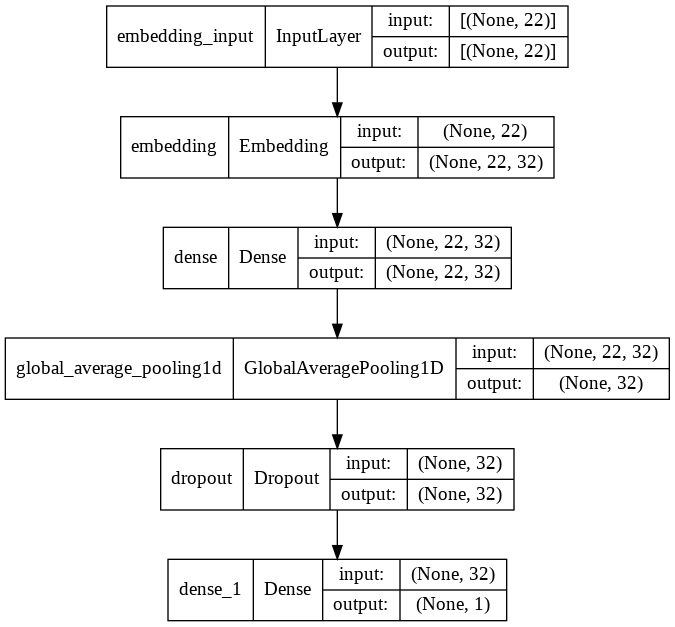

In [ ]:
from keras.utils.vis_utils import plot_model

np.random.seed(123) #np seed 
set_random_seed(2) #keras seed

vocab_size = num_word

embedding_dim = 32
model2 = tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length=max_length),
              tf.keras.layers.Dense(embedding_dim,activation='relu'),
              tf.keras.layers.GlobalAveragePooling1D(),
              tf.keras.layers.Dropout(0.1),
              tf.keras.layers.Dense(1,activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())
plot_model(model2, show_shapes= True)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=1, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.1)

history = model2.fit(X_train, np.array(y_train), epochs=5, batch_size=16, verbose=1, 
           validation_data=(X_val,np.array(y_val)),
           callbacks=[lr_reduction])

y_train_pred = model2.predict(X_train)
y_val_pred = model2.predict(X_val)  

Epoch 1/5
328/328 [==============================] - 4s 8ms/step - loss: 0.6305 - accuracy: 0.6397 - val_loss: 0.5222 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 2/5
328/328 [==============================] - 3s 8ms/step - loss: 0.3760 - accuracy: 0.8528 - val_loss: 0.3814 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 3/5
328/328 [==============================] - 2s 8ms/step - loss: 0.2367 - accuracy: 0.9142 - val_loss: 0.3599 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 4/5
328/328 [==============================] - 2s 7ms/step - loss: 0.1639 - accuracy: 0.9455 - val_loss: 0.3640 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 5/5
328/328 [==============================] - 2s 7ms/step - loss: 0.1123 - accuracy: 0.9661 - val_loss: 0.3628 - val_accuracy: 0.8476 - lr: 0.0010


***Analyzing Missclassified Tweet***
<br>
Below are the possibilities why tweets are being missclassified: 
1. Label in the training data are not 100% accurate 
for example :
<br>@camilacabello97 Internally and externally screaming screaming --> 1

In [ ]:
#checking wrong detection 

predicted_train = np.round(model2.predict(X_train, batch_size=0))
X_text = tokenizer.sequences_to_texts(X_train)
#dict_train=dict(zip(y_train.index, [X_text,y_train, predicted_train]))
miss_0=0
miss_1=0
for i,y in enumerate(y_train): 
  if y != predicted_train[i]:
    
    print(i,y, predicted_train[i], X_text[i])
    if y == 0: 
      miss_0+=1
    if y == 1: 
      miss_1+=1

print(miss_0,miss_1)

17 1 [0.] burn michael haha would ball burn
22 1 [0.] traumatise disneyirh traumatise
106 0 [1.] sinkhole selfies believe brooklyn sinkhole sinkhole selfies belie
156 0 [1.] hail user summon hailstorm last five turn damage pokemon except type
515 1 [0.] meltdown meltdown victory mets
517 1 [0.] drown drown like time damn game today
522 1 [0.] drown drown child
527 1 [0.] panic panic make tire want sleep
570 1 [0.] flatten flatten thee striker
625 1 [0.] danger bluebirddenver fettilootch slanglucci oppressions greatest danger come soon album
654 1 [0.] crush sevenfigz crush
666 0 [1.] gays totally destroy america build burn meteors crash school
684 1 [0.] fire want shit fire
711 1 [0.] lava check lava lamp dude
779 1 [0.] rainstorm rainstorm last nearailway long enough
865 1 [0.] curfew emmychappy clock say everyone home curfew
911 1 [0.] blaze love live blaze inside balcony
933 1 [0.] harm never escape bullets harm nothing harm know pain know pain sometimes share someone like
980 1 [0.

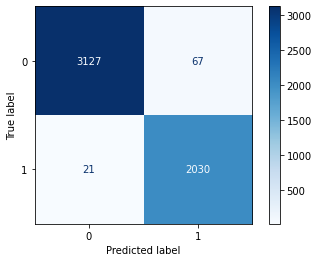

In [ ]:
#Confusion Matrix Training Set  
predicted_train = model2.predict(X_train, batch_size=32)
class_pred_train= np.round(predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_pred_train,y_train), display_labels=np.unique(y_val))
disp.plot(cmap='Blues') 
plt.grid(False)

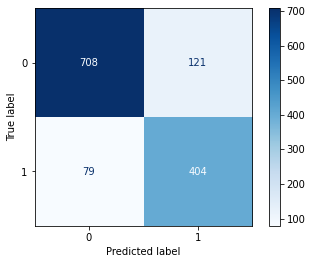

In [ ]:
#Confusion Matrix Validation 
predicted_val = model2.predict(X_val, batch_size=32)
class_pred_val= np.round(predicted_val)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_pred_val,y_val), display_labels=np.unique(y_val))
disp.plot(cmap='Blues') 
plt.grid(False)

In [ ]:
predicted_val = model2.predict(test_padded, batch_size=8)
class_predict = np.round(predicted_val)
class_predict=class_predict.astype("Int32")
#download the file
X_test_id = test_csv["id"].values.astype("Int32") # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)
download_predictions_to_file(X_test_id, class_predict) # download the prediction file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

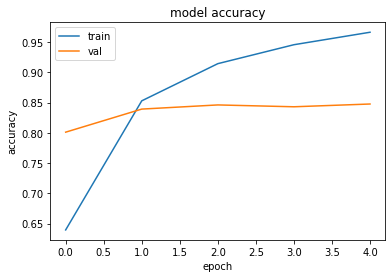

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

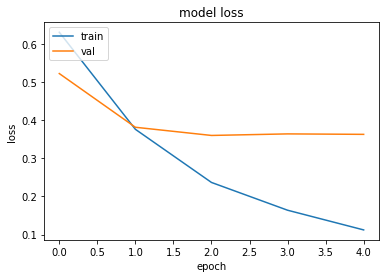

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()